
# Creating Activation Atlases with captum.optim

This notebook demonstrates the use of the captum.optim submodule for creation of [Activation Atlases](https://distill.pub/2019/activation-atlas/) for the InceptionV1 model imported from Caffe.


In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from captum.optim._models.inception_v1 import googlenet

import captum.optim as optimviz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = googlenet(pretrained=True).to(device).eval()

We'll define some helper functions:

In [ ]:
from typing import List, Optional, Tuple, Union
from PIL import Image


def show(
    x: torch.Tensor, figsize: Optional[Tuple[int, int]] = None, scale: float = 255.0
) -> None:
    """
    Show CHW & NCHW tensors as an image.
    Args:
        x (torch.Tensor): The tensor you want to save as an image.
        figsize (Tuple[int, int], optional): height & width to use
            for displaying the image figure.
        scale (float): Value to multiply the input tensor by so that
            it's value range is [0-255] for display.
    """
    assert x.dim() == 3 or x.dim() == 4
    x = x[0] if x.dim() == 4 else x
    x = x.cpu().permute(1, 2, 0) * scale
    if figsize is not None:
        plt.figure(figsize=figsize)
    plt.imshow(x.numpy().astype(np.uint8))
    plt.axis("off")
    plt.show()


def save_tensor_as_image(x: torch.Tensor, filename: str, scale: float = 255.0) -> None:
    """
    Save CHW & NCHW image tensors as images.
    Args:
        x (torch.Tensor): The tensor you want to save as an image.
        filename (str): The filename to use when saving the image.
        scale (float, optional): Value to multiply the input tensor by so that
            it's value range is [0-255] for saving.
    """
    assert x.dim() == 3 or x.dim() == 4
    x = x[0] if x.dim() == 4 else x
    x = x.clone().detach().cpu().permute(1, 2, 0) * scale
    colorspace = "RGB" if x.shape[2] == 3 else "RGBA"
    im = Image.fromarray(x.numpy().astype(np.uint8), colorspace)
    im.save(filename)


def create_alpha_mask(
    h: int,
    w: int,
    vec_coords: List[Union[Tuple[int, int, int], Tuple[int, int]]],
    device: torch.device = torch.device("cpu"),
) -> torch.tensor:
    """
    Create an alpha mask to make an activation atlas background transparent.

    Args:
       h (int): The height of each cell.
       w (int): the width of each cell.
       vec_coords (List[Union[Tuple[int, int, int], Tuple[int, int]]]): A list of
           atlas coordinates to use for creating the mask.
       device (torch.device, optional): The device that the cells are on.
    Returns:
       alpha_mask (torch.Tensor): An alpha mask tensor used to make an atlas
           background transparent.
    """

    return optimviz.atlas.create_atlas(
        [torch.ones(1, 1, h, w, device=device) for n in vec_coords],
        vec_coords,
        grid_size=grid_size,
        base_tensor=torch.zeros,
    )

# Atlas Setup

**Note that this step is optional for this tutorial**. To create an activation atlas for our model, we need to collect activation samples while using the dataset that the model was trained on. In the case of the Inception V1 model, we use the training images from ImageNet's ILSVRC2012 dataset. Due to the size of the ILSVRC2012 dataset, we'll skip the sample collection step and just some download precollected samples. If you do however want to collect your own samples then you can follow the steps below.

### Dataset Download & Activation Sample Collection (Optional)
You can download ImageNet's ILSVRC2012 dataset from the [ImageNet website](http://www.image-net.org/challenges/LSVRC/2012/) or via BitTorrent from [Academic Torrents](https://academictorrents.com/details/a306397ccf9c2ead27155983c254227c0fd938e2). Once the dataset is downloaded, you can then load it with a `torch.utils.DataLoader` instance, and Torchvision's `torchvision.datasets.ImageNet`.


With the ImageNet ILSVRC2012 dataset loaded, you can randomly sample an x and y position in every image for all target layers with Captum's `capture_activation_samples` function.

In [ ]:
"""
# torch.utils.DataLoader instance with your dataset
image_dataset = torchvision.datasets.ImageNet(root="path/to/dataset", split="train")

targets = [model.mixed4c]
target_names = ["mixed4c"]

# Enable the InceptionV1 model's internal BGR transform
# before capturing samples
model.bgr_transform = True

sample_dir="inceptionv1_samples"

optimviz.dataset.capture_activation_samples(
    loader=image_dataset,
    model=model,
    targets=targets,
    target_names=target_names,
    sample_dir=sample_dir,
    show_progress=True,
)

# Combine our newly collect samples into a single tensor
activation_samples = optimviz.dataset.consolidate_samples(sample_dir=sample_dir)

# Disable the InceptionV1 model's internal BGR transform
# before creating visualizations
model.bgr_transform = False
"""

Download the precollected samples:

In [ ]:
fileurl = "mixed4c_layer_samples.pt"
activation_samples = torch.hub.download_url_to_file(
    url, "mixed4c_layer_samples.pt", progress=True
).to(device)

fileurl = "mixed4c_layer_samples_umap.pt"
umap_activation_samples = torch.hub.download_url_to_file(
    url, "mixed4c_layer_samples_umap.pt", progress=True
).to(device)

## Dimensionality Reduction For Activation Atlas Grid Creation

Now that we have our dataset activation samples for the Mixed4c layer, we can use either UMAP or Sklearn's TSNE to reduce the number of channels to 2. Having only two channels will let us treat the activation samples as x and y positions on a graph. 

Before graphing the reduced activation samples, we normalize them in order to remove outliers. Note that we only need to normalize the graph when we want to plot it using a graphing library like `matplotlib`.

Note that precomputed UMAP reduced samples are used to create the atlas vectors in the next step. The UMAP reduced samples created in this step are purely to show how how you can create your own. 

UMAP(a=None, angular_rp_forest=True, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='cosine', metric_kwds=None,
     min_dist=0.01, n_components=2, n_epochs=None, n_jobs=-1, n_neighbors=20,
     negative_sample_rate=5, output_dens=False, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, ...)
Construct fuzzy simplicial set
Mon Feb  1 18:57:19 2021 Finding Nearest Neighbors
Mon Feb  1 18:57:19 2021 Building RP forest with 16 trees
Mon Feb  1 18:57:24 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	Stopping threshold met -- exiting after 6 iterations
Mon Feb  1 18:57:50 2021 Finished Nearest Neighbor S

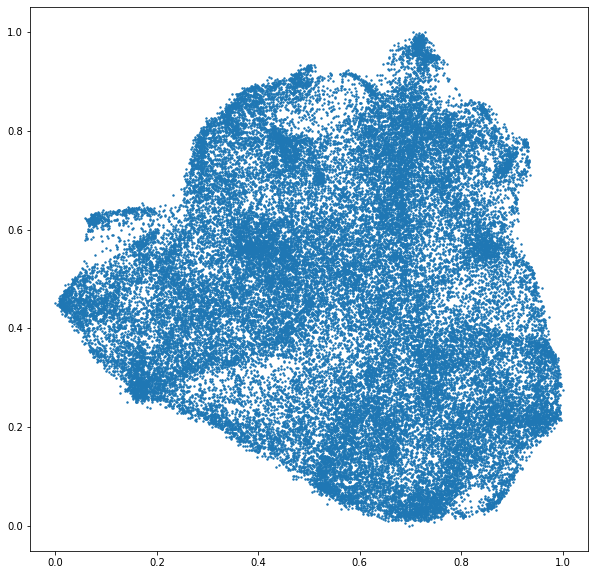

In [ ]:
import umap

c_reducer = optimviz.reducer.ChannelReducer(
    n_components=2,
    reduction_alg=umap.UMAP,
    verbose=True,
    n_neighbors=20,
    min_dist=0.01,
    metric="cosine",
)
# You can also use TSNE instead of UMAP if desired:
# from sklearn.manifold import TSNE
# c_reducer = optimviz.reducer.ChannelReducer(
#    n_components=2,
#    reduction_alg=TSNE,
#    verbose=True,
#    metric="cosine",
#    learning_rate=10,
#    perplexity=50,
# )

# Take 50000 random samples to visualize so that
# we avoid out of memory errors
samples_for_umap = activation_samples[:50000, :]
umap_activ_samples = c_reducer.fit_transform(samples_for_umap)

# Normalize umap reduced activation samples for graph
normalized_umap = optimviz.atlas.normalize_grid(umap_activ_samples)

# Show the normalized umap reduced activation samples
plt.figure(figsize=(10, 10))
plt.scatter(x=normalized_umap[:, 0], y=normalized_umap[:, 1], s=2)
plt.show()

## Activation Atlas Vectors & Coordinates

Now we can use both the raw Mixed4c activation samples and our dimensionality reduced activation samples to create the direction vectors for generating visualizations. The `create_atlas_vectors` function will return a set of direction vectors and a list of coordinations for creating the activation atlas image. 

When creating our atlas, the `grid_size` parameter defines how big our atlas should be.

In [ ]:
grid_size = (40, 40)
vecs, vec_coords = optimviz.atlas.create_atlas_vectors(
    umap_activation_samples, activation_samples, grid_size=grid_size
)

## Activation Atlas Heatmap & Shape

We can now easily see the shape of our atlas before rendering all of the images, then we can simply do this:

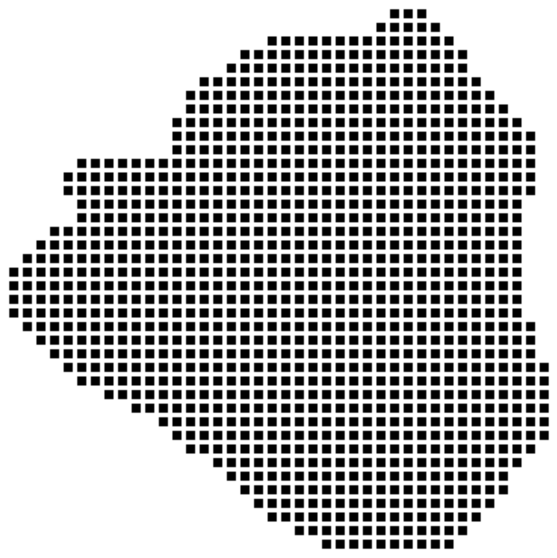

In [ ]:
import torch.nn.functional as F

atlas_bw_tensors = [
    F.pad(torch.ones(1, 3, 4, 4) * 255, (1, 1, 1, 1), value=1) for n in vec_coords
]
atlas_bw = optimviz.atlas.create_atlas(
    atlas_bw_tensors, vec_coords, grid_size=grid_size
)

# Make background transparent
alpha_bw_mask = create_alpha_mask(6, 6, device=atlas_bw.device)
atlas_bw = torch.cat([atlas_bw, alpha_bw_mask], 1)

show(atlas_bw, figsize=(10, 10))

We can also see which cells have the most samples like so (the darker the color, the more activation samples used):

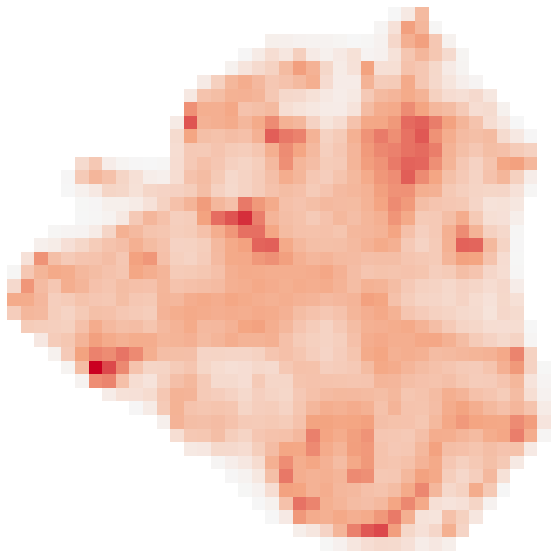

In [ ]:
atlas_hm_tensors = [torch.ones(1, 1, 1, 1) * n[2] for n in vec_coords]
atlas_hm = optimviz.atlas.create_atlas(
    atlas_hm_tensors, vec_coords, grid_size=grid_size
)
atlas_hm = atlas_hm / atlas_hm.max()
atlas_hm = optimviz.weights_to_heatmap_2d(atlas_hm[0, 0])

# Make background transparent
alpha_hm_mask = create_alpha_mask(1, 1, device=atlas_hm.device)
atlas_hm = torch.cat([atlas_hm.unsqueeze(0), alpha_hm_mask], 1)

show(atlas_hm, figsize=(10, 10))

# Creating The Activation Atlas Visualizations

Now we should everything we need to start creating the visualizations for each activation atlas cell!

Below we define two helper functions to help us visualize all the atlas vectors that we created above by using the `create_atlas_vectors` function. To create the visualizations for our atlas we will use the `WhitenedNeuronDirection` objective.

In [ ]:
def vis_neuron_direction(
    model: torch.nn.Module,
    target: torch.nn.Module,
    vec: torch.Tensor,
    vec_whitened: torch.Tensor,
) -> torch.Tensor:
    image = optimviz.images.NaturalImage((80, 80)).to(device)
    loss_fn = optimviz.loss.WhitenedNeuronDirection(
        target, vec, vec_whitened, cossim_pow=4.0
    )
    transforms = torch.nn.Sequential(
        torch.nn.ConstantPad2d(2, value=1.0),
        optimviz.transform.RandomSpatialJitter(4),
        optimviz.transform.RandomSpatialJitter(4),
        optimviz.transform.RandomSpatialJitter(8),
        optimviz.transform.RandomSpatialJitter(8),
        optimviz.transform.RandomSpatialJitter(8),
        optimviz.transform.RandomScale(
            scale=[0.995 ** n for n in range(-5, 80)]
            + [0.998 ** n for n in 2 * list(range(20, 40))]
        ),
        optimviz.transform.RandomRotation(
            degrees=list(range(-20, 20))
            + list(range(-10, 10))
            + list(range(-5, 5))
            + 5 * [0]
        ),
        optimviz.transform.RandomSpatialJitter(2),
    )
    obj = optimviz.InputOptimization(model, image, transforms, [target], loss_fn)
    history = obj.optimize(optimviz.objectives.n_steps(128, False))
    return image()._t, history[-1]

We whiten the raw Mixed4c activation samples for the `WhitenedNeuronDirection` objective:

In [ ]:
# Whiten the raw activations
whitend_activation_samples = torch.inverse(
    torch.matmul(activation_samples.T, activation_samples)
    / len(activation_samples)
)

To generate all of the activation atlas images, we'll iterate through all the previously calculated direction vectors. To monitor our progress, we can use the `tqdm` library.

In [ ]:
from tqdm import tqdm

A = []
num_attempts = 1

for i in tqdm(range(vecs.size(0)), position=0, leave=True):
    attempts, loss_list = [], []
    for a in range(num_attempts):
        img, loss = vis_neuron_direction(
            model, model.mixed4c, vec=vecs[i], vec_whitened=whitend_activation_samples
        )
        attempts.append(img.detach().cpu())
        loss_list.append(loss)

    A.append(attempts[np.argmax(np.asarray(loss_list))])

100%|██████████| 1085/1085 [1:02:31<00:00,  3.46s/it]


Now we put all the images together using the cell coordinates that we previously calculated! And what's more, the UMAP reduced scatter plot graph we created above has the same shape as the full atlas image!

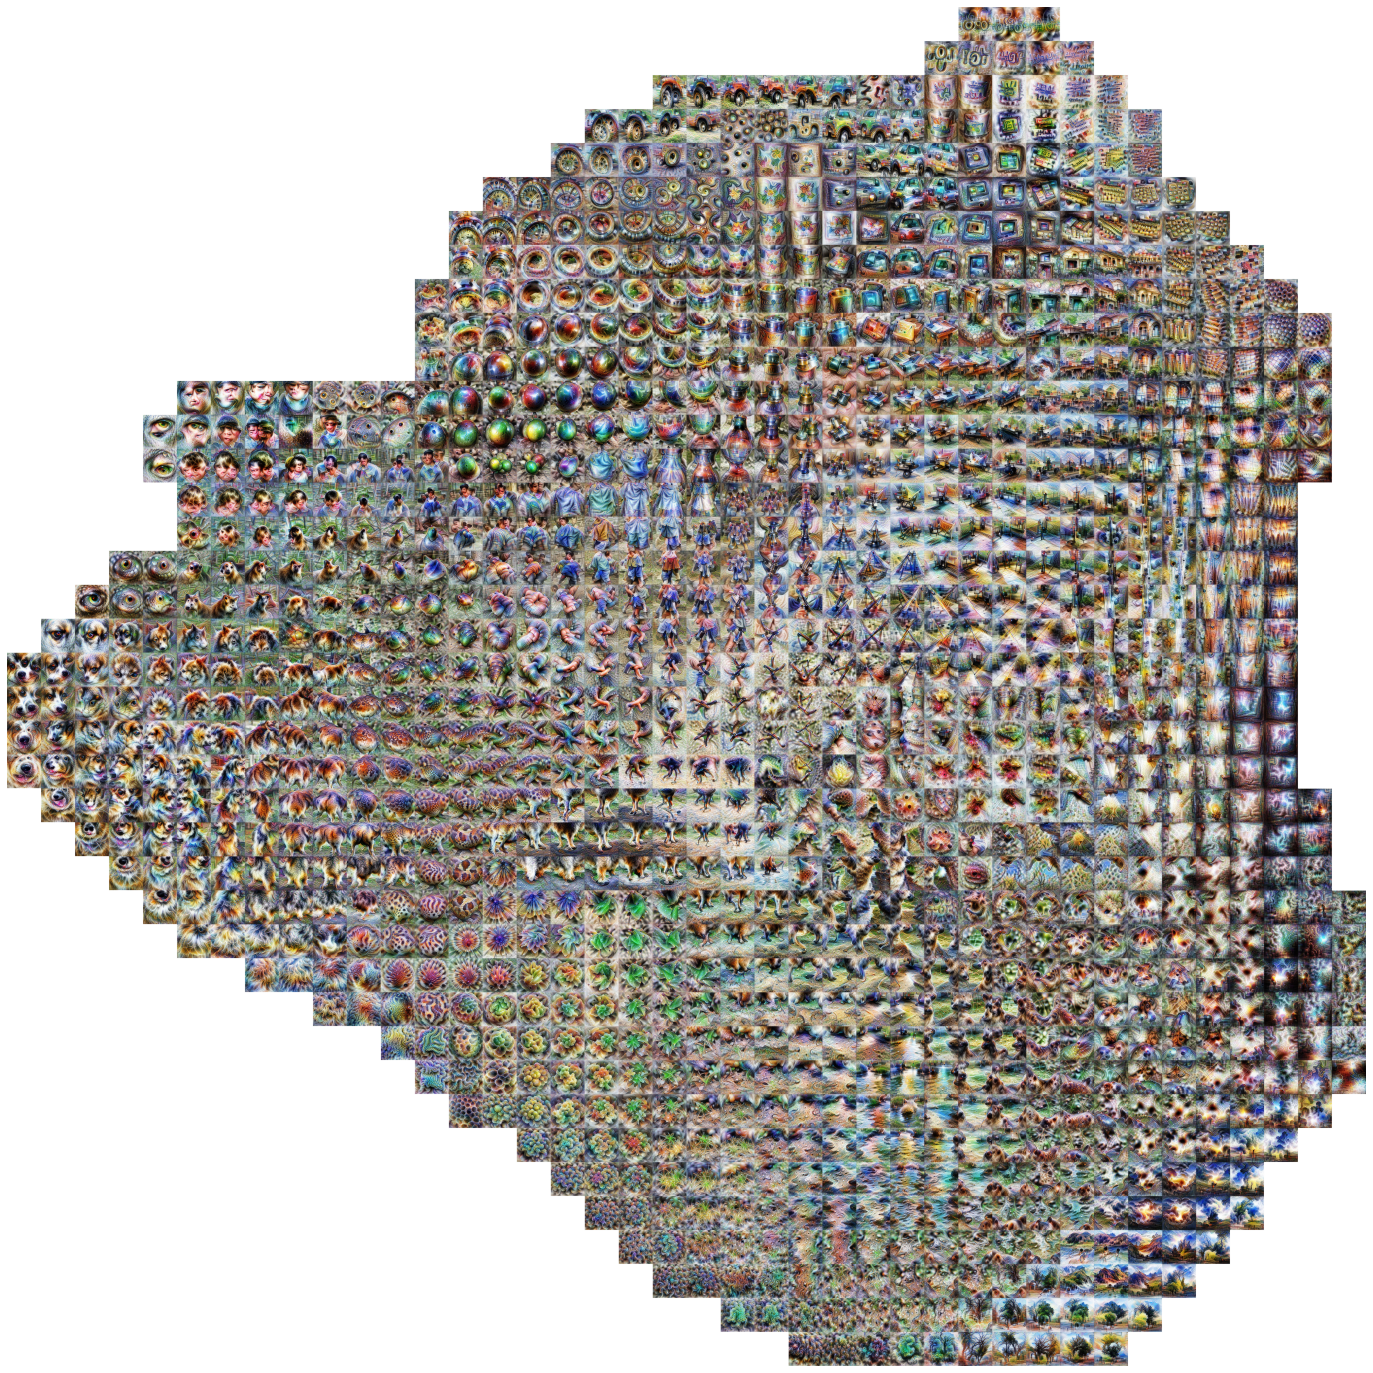

In [ ]:
atlas_img = optimviz.atlas.create_atlas(A, vec_coords, grid_size=grid_size)

# Make background transparent
alpha_mask = create_alpha_mask(*A[0].shape[2:], device=atlas_img.device)
atlas_img = torch.cat([atlas_img, alpha_mask], 1)

# Save atlas as image and show it to user
save_tensor_as_image(atlas_img.detach(), "atlas.png")
show(atlas_img.detach(), figsize=(25, 25))